# Load Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from collections import defaultdict

In [13]:
import numpy as np

# Laod dataset

In [103]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELES=3
EPOCHS=10

In [136]:
train_data =tf.keras.preprocessing.image_dataset_from_directory(
    'Dataset/train',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
    
    
)

Found 1721 files belonging to 3 classes.


In [138]:
class_name = train_data.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [52]:
train_ds =tf.keras.preprocessing.image_dataset_from_directory(
    'Dataset/train',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
    
    
)

Found 1721 files belonging to 3 classes.


In [57]:
len(train_ds)

54

# count_samples_per_class

In [33]:
def count_samples_per_class(dataset):
    """
    Count the number of samples in each class in a TensorFlow dataset.

    Args:
    dataset (tf.data.Dataset): The TensorFlow dataset containing images and labels.

    Returns:
    dict: A dictionary where keys are class names and values are the count of samples in each class.
    """
    # Ensure dataset is in a form where it has labels
    if not hasattr(dataset, 'class_names'):
        raise ValueError("The provided dataset does not have 'class_names'. Make sure to use 'tf.keras.preprocessing.image_dataset_from_directory' to load the dataset.")
    
    # Get class names from dataset
    class_names = dataset.class_names

    # Initialize a dictionary to count samples
    class_counts = defaultdict(int)

    # Iterate through the dataset to count samples
    for images, labels in dataset:
        for label in labels:
            class_counts[class_names[label.numpy()]] += 1

    return dict(class_counts)

In [54]:
class_counts = count_samples_per_class(train_ds)
for class_name, count in class_counts.items():
    print(f"Class '{class_name}' has {count} samples.")

Class 'Potato___Late_blight' has 800 samples.
Class 'Potato___Early_blight' has 800 samples.
Class 'Potato___healthy' has 121 samples.


In [55]:
val_dataset =tf.keras.preprocessing.image_dataset_from_directory(
    'Dataset/val',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
    
    
)

Found 431 files belonging to 3 classes.


In [56]:
class_counts = count_samples_per_class(val_dataset)
for class_name, count in class_counts.items():
    print(f"Class '{class_name}' has {count} samples.")

Class 'Potato___Late_blight' has 200 samples.
Class 'Potato___Early_blight' has 200 samples.
Class 'Potato___healthy' has 31 samples.


In [15]:
for image_batch , label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 0 1 0 0 1 0 1 0 2 2 1 0 0 0 2 1 0 0 0 1 1 1 1 2 0 1 1 1]


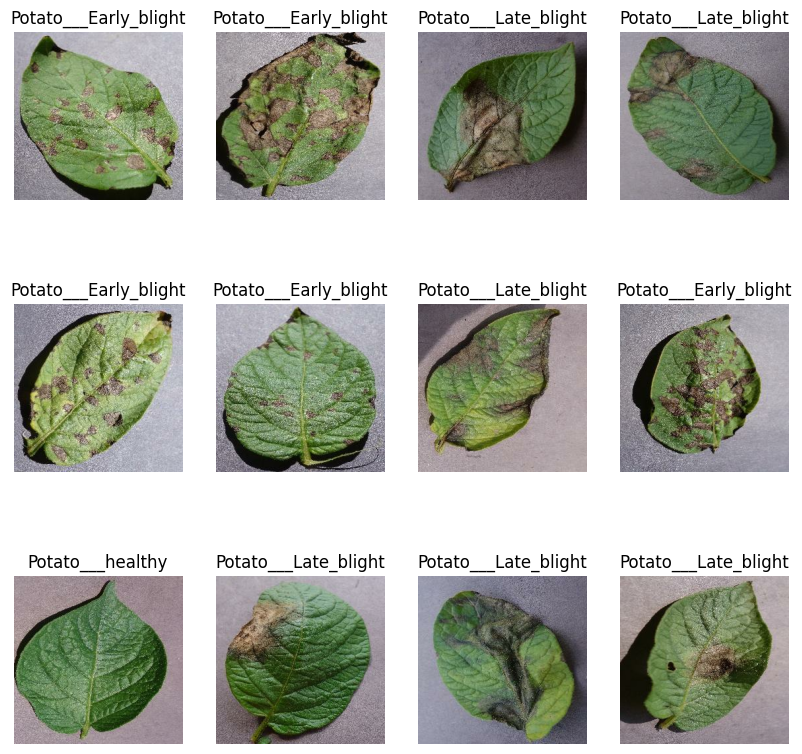

In [25]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_name[label_batch[i]])
        plt.axis('off')
    
    

Split Val Dataset Test and Val Data

In [45]:
# len(val_dataset)
# test_size=0.5
# len(val_dataset)*test_size
# # take 1st 7 batch for test 
# test_data=val_dataset.take(7)

# #take next 7 batch for val data
# val_data=val_dataset.skip(7)

14

In [49]:
def get_test_val_data(ds, test_split=0.5, val_split=0.5, shuffle=True, Shuffle_size=1000):
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(Shuffle_size,seed=12)
    
    test_size=int(test_split*ds_size)
    # val_size=int(val_split*ds_size)
    
    test_ds=ds.take(test_size)
    val_ds=ds.skip(test_size)
    
    return test_ds, val_ds
    

In [50]:
test_ds, val_ds=get_test_val_data(val_dataset)

In [51]:
len(test_ds) , len(val_ds)

(7, 7)

In [58]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Preprocessing

In [64]:
resize_and_rescale=tf.keras.Sequential(
    [
        layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
        layers.Rescaling(1.0/255)
    ]
)

In [65]:
data_augmentation=tf.keras.Sequential(
    [
        layers.RandomFlip('HORIZONTAL_AND_VERTICAL'),
        layers.RandomRotation(0.2),
    ]
)

In [104]:

input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELES)
n_classes=3
# Define the Sequential model
model = models.Sequential([
    resize_and_rescale,  # Resizing and rescaling layers
    data_augmentation,   # Data augmentation layer

    # Define the first layer with input_shape
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    # Additional convolutional and pooling layers
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten the output before feeding it into dense layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')  # Output layer with softmax activation
])

/Users/mst.sadiakhatun/Desktop/Potato disease Classification/cv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [105]:
model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_92 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_92 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_93 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_93 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_94 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_95 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_96 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_96 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,891 (1.06 MB)

 Trainable params: 277,891 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [106]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
    
)

In [107]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.4928 - loss: 0.9264 - val_accuracy: 0.7343 - val_loss: 0.6818
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.7809 - loss: 0.5514 - val_accuracy: 0.7971 - val_loss: 0.5347
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8624 - loss: 0.3659 - val_accuracy: 0.8502 - val_loss: 0.3939
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8719 - loss: 0.3000 - val_accuracy: 0.9372 - val_loss: 0.1891
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9254 - loss: 0.2030 - val_accuracy: 0.9324 - val_loss: 0.1867
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9344 - loss: 0.1957 - val_accuracy: 0.9469 - val_loss: 0.1338
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9303 - loss: 0.1665 - val_accuracy: 0.9565 - val_loss: 0.1314
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9346 - loss: 0.1694 - val_accuracy: 0.9469 - val_loss:

In [108]:
scores =model.evaluate(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 325ms/step - accuracy: 0.9748 - loss: 0.0941


In [109]:
scores

[0.11630187183618546, 0.9613526463508606]

In [110]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [111]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [114]:
history.history['accuracy']

[0.5299244523048401,
 0.8006972670555115,
 0.8744915723800659,
 0.8855316638946533,
 0.9198140501976013,
 0.9401510953903198,
 0.9279488921165466,
 0.9418942332267761,
 0.944799542427063,
 0.9535154104232788]

In [115]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

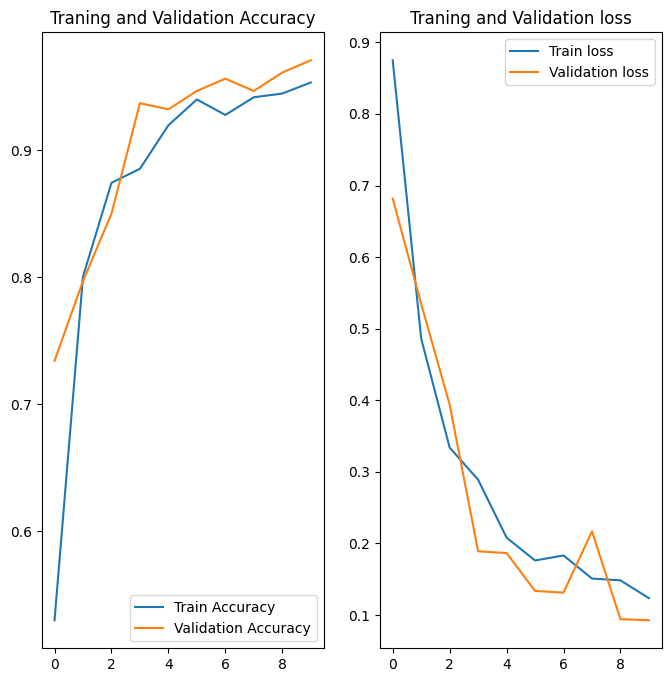

In [128]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Train Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title('Traning and Validation Accuracy')



plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Train loss")
plt.plot(range(EPOCHS), val_loss, label="Validation loss")
plt.legend(loc='upper right')
plt.title('Traning and Validation loss')
plt.show()

In [139]:
class_names=['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

First image to predict
first image  actual label : Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
Potato___Early_blight


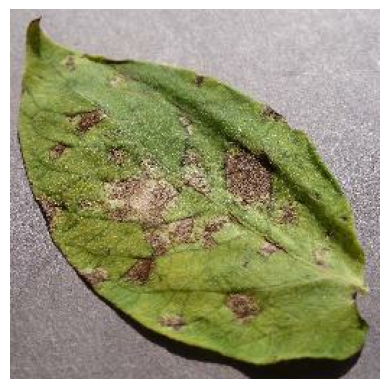

In [167]:
for image_batch ,label_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    first__label=label_batch[0].numpy()
    
    print('First image to predict')
    plt.axis('off')
    plt.imshow(first_image)
    
    print('first image  actual label :',class_names[first__label])
    
    batch_prediction=model.predict(image_batch)
    print(class_names[np.argmax(batch_prediction[0])])

In [168]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


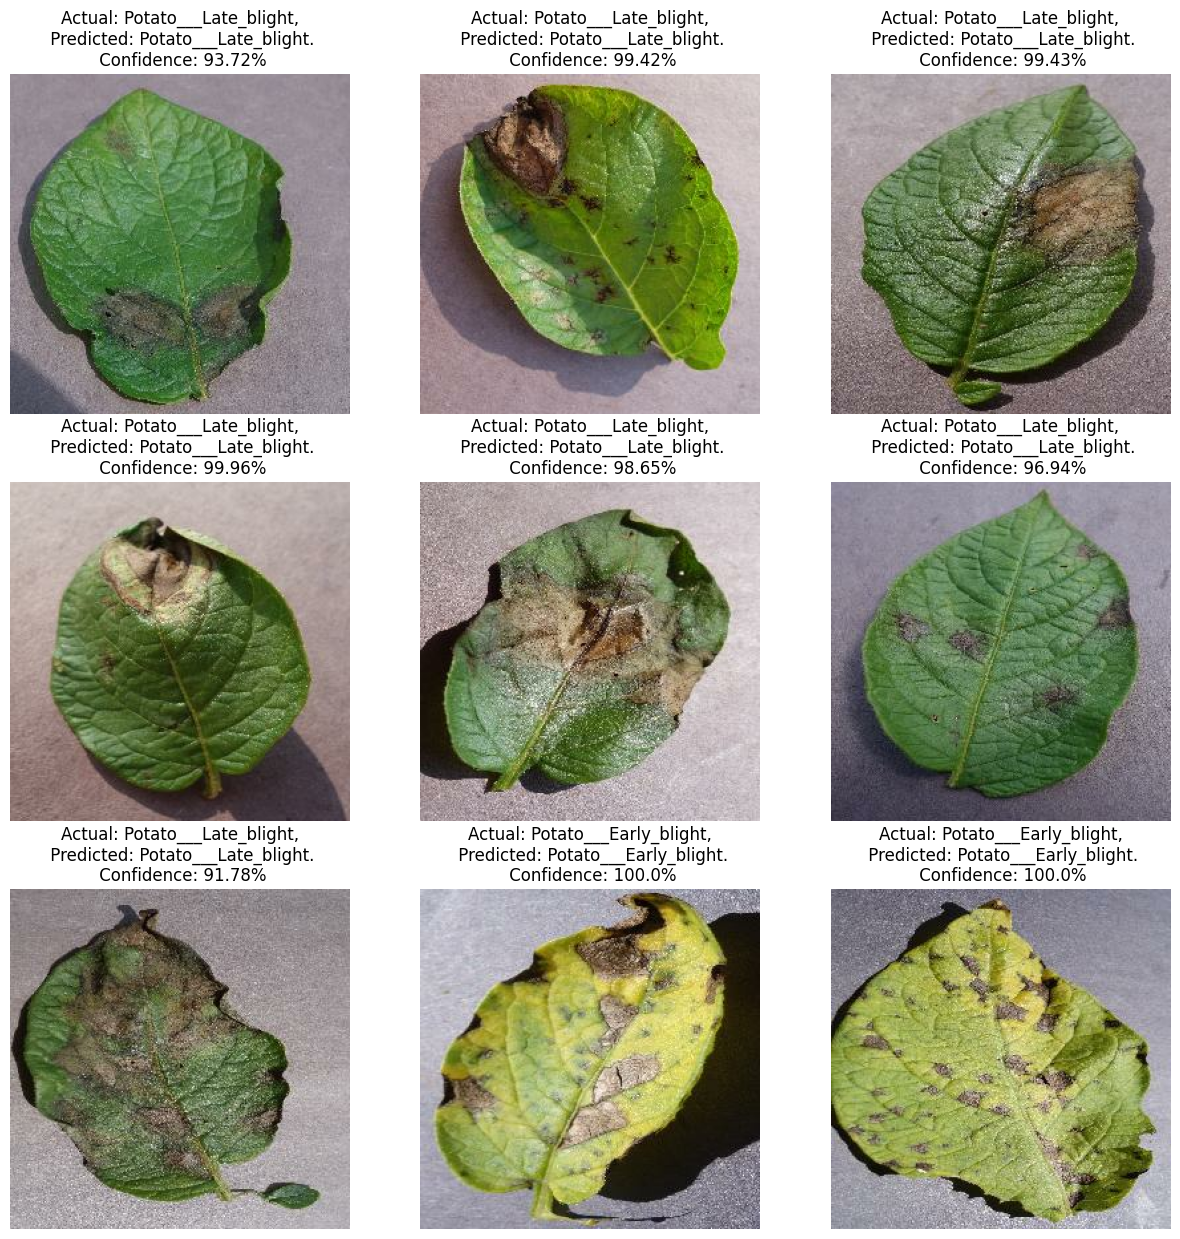

In [169]:

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


# Saving The Model

In [180]:
import os

# Determine the next model version number
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1

# Save the model with a `.h5` extension
model.save(f"../models/Potato_v{model_version}.keras")

In [183]:
my_model = tf.keras.models.load_model('my_model.keras')

In [184]:
my_model.predict(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step


array([[4.26562339e-01, 5.73262334e-01, 1.75375259e-04],
       [9.99988437e-01, 1.15584080e-05, 4.43388082e-18],
       [1.63769022e-01, 8.35836709e-01, 3.94246366e-04],
       [9.99963582e-01, 3.64576736e-05, 2.50727851e-13],
       [9.49416310e-04, 9.99020338e-01, 3.02183471e-05],
       [9.16513163e-05, 9.94935930e-01, 4.97244298e-03],
       [9.89462793e-01, 1.05351722e-02, 2.03677519e-06],
       [1.96723384e-03, 9.39932704e-01, 5.81000745e-02],
       [4.22843332e-05, 9.99608696e-01, 3.49027454e-04],
       [3.73762753e-03, 9.55240667e-01, 4.10217494e-02],
       [9.97527242e-01, 2.46964744e-03, 3.09549660e-06],
       [9.99961674e-01, 3.84339692e-05, 5.47157146e-11],
       [2.44629439e-02, 9.73729253e-01, 1.80779351e-03],
       [9.97830153e-01, 2.16991920e-03, 4.08945187e-12],
       [1.54470361e-03, 9.97719049e-01, 7.36194721e-04],
       [4.45260778e-02, 9.55471277e-01, 2.64542905e-06],
       [9.82909083e-01, 1.70909166e-02, 2.64447575e-08],
       [8.00809916e-03, 9.90755

In [187]:
model.evaluate(train_ds)

54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 341ms/step - accuracy: 0.9679 - loss: 0.1042


[0.09807545691728592, 0.9674607515335083]

In [189]:
my_model2 = tf.keras.models.load_model('/Users/mst.sadiakhatun/Desktop/Potato disease Classification/models/Potato_v1.keras')

In [190]:
my_model2.evaluate(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 338ms/step - accuracy: 0.9526 - loss: 0.1316


[0.11630187928676605, 0.9613526463508606]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


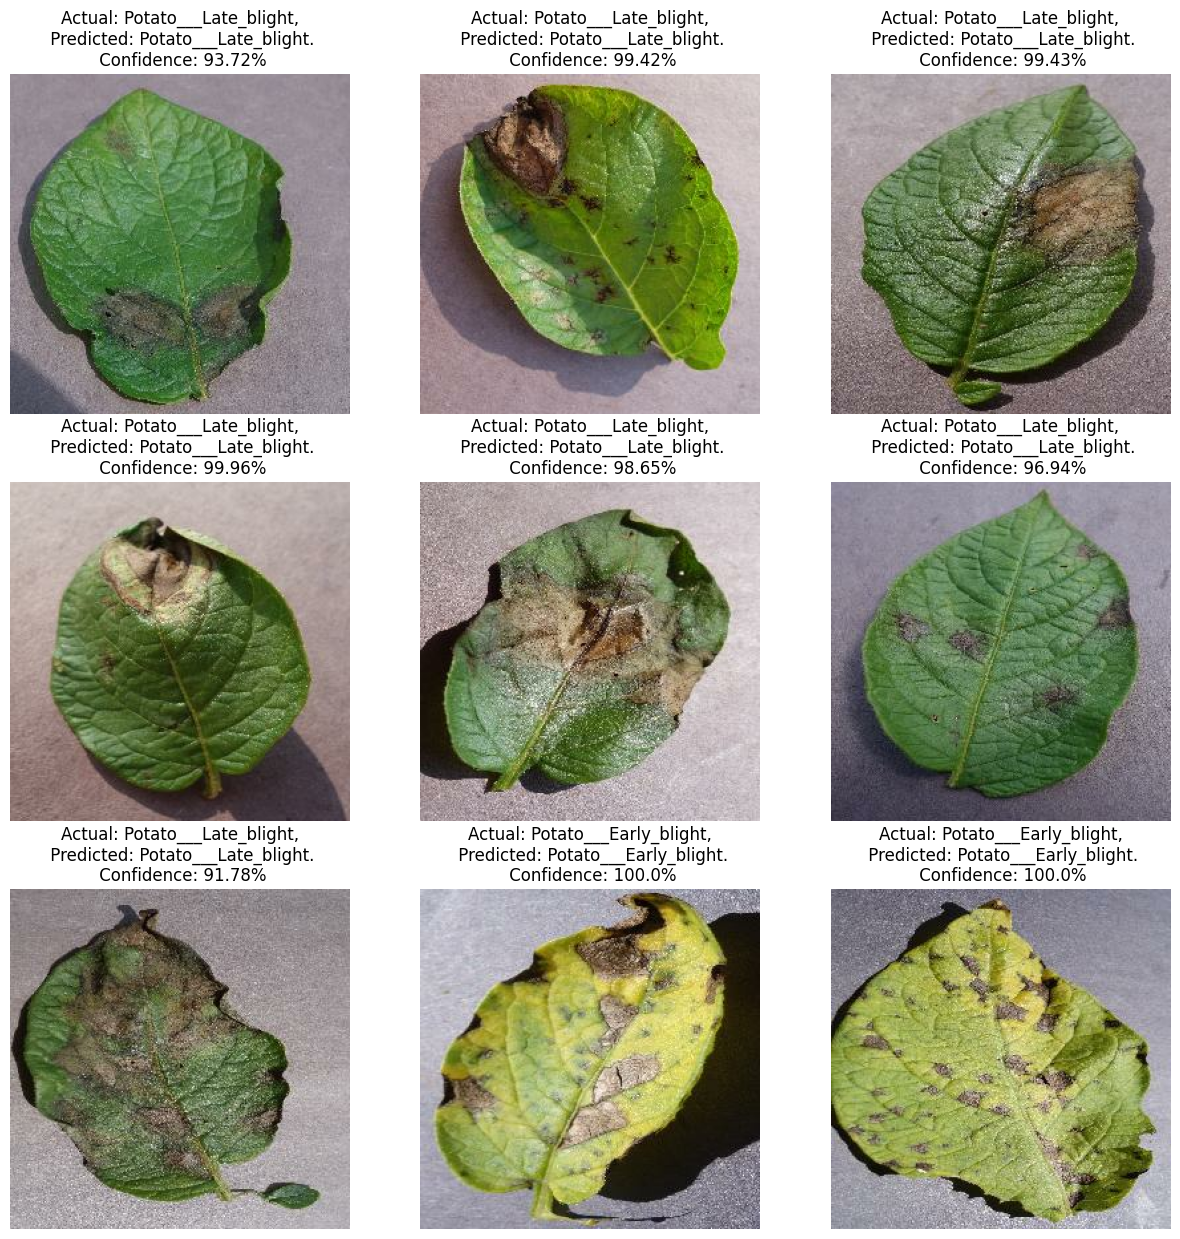

In [191]:

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(my_model2, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [196]:
for images, labels in test_ds.take(1):
    print(images[0]/255.0)

tf.Tensor(
[[[0.6431373  0.61960787 0.63529414]
  [0.6431373  0.61960787 0.63529414]
  [0.6431373  0.61960787 0.63529414]
  ...
  [0.6745098  0.6509804  0.6666667 ]
  [0.64705884 0.62352943 0.6392157 ]
  [0.6039216  0.5803922  0.59607846]]

 [[0.6392157  0.6156863  0.6313726 ]
  [0.6392157  0.6156863  0.6313726 ]
  [0.6392157  0.6156863  0.6313726 ]
  ...
  [0.7294118  0.7058824  0.72156864]
  [0.7294118  0.7058824  0.72156864]
  [0.70980394 0.6862745  0.7019608 ]]

 [[0.6313726  0.60784316 0.62352943]
  [0.63529414 0.6117647  0.627451  ]
  [0.63529414 0.6117647  0.627451  ]
  ...
  [0.627451   0.6039216  0.61960787]
  [0.61960787 0.59607846 0.6117647 ]
  [0.59607846 0.57254905 0.5882353 ]]

 ...

 [[0.5882353  0.5647059  0.57254905]
  [0.5921569  0.5686275  0.5764706 ]
  [0.6        0.5764706  0.58431375]
  ...
  [0.5568628  0.5176471  0.5137255 ]
  [0.5529412  0.5137255  0.50980395]
  [0.5294118  0.49019608 0.4862745 ]]

 [[0.5882353  0.5647059  0.57254905]
  [0.5882353  0.5647059  0